This notebook has been prepared by Dennis P. Trujillo.

It shows the following:

1. How causal networks can be constructed using the important features to investigate relationships between cancer treatments and local tumor reccurrence.

Install packages

In [ ]:
!pip install -q lingam
!pip install -q igraph
!pip install -q pygam
!pip install -q factor_analyzer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.7/95.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


Import essential libraries

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor
import json
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import graphviz
import lingam
from lingam.utils import make_prior_knowledge
from sklearn.linear_model import LogisticRegression

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
patient_data='/content/drive/MyDrive/duke-mri-cleaned-tabular/duke-mri.csv'

Read in dataset

In [ ]:
df = pd.read_csv(patient_data, on_bad_lines='skip').set_index('Patient ID')

In [ ]:
endpoint ='Days to last local recurrence free assessment (from the date of diagnosis)'

In [ ]:
df.columns

Index(['Date of Birth (Days)', 'Menopause (at diagnosis)',
       'Race and Ethnicity',
       'Metastatic at Presentation (Outside of Lymph Nodes)', 'ER', 'PR',
       'HER2', 'Mol Subtype', 'Staging(Tumor Size)# [T]',
       'Staging(Nodes)#(Nx replaced by -1)[N]',
       'Staging(Metastasis)#(Mx -replaced by -1)[M]',
       'Tumor Grade(T)\n(Tubule)', 'Tumor Grade(N)\n(Nuclear)',
       'Tumor Grade(M)\n(Mitotic)', 'Multicentric/Multifocal',
       'Contralateral Breast Involvement',
       'Lymphadenopathy or Suspicious Nodes', 'Skin/Nipple Invovlement',
       'Pec/Chest Involvement', 'Surgery',
       'Days to Surgery (from the date of diagnosis)',
       'Definitive Surgery Type', 'Neoadjuvant Radiation Therapy',
       'Adjuvant Radiation Therapy', 'Recurrence event(s)',
       'Days to last local recurrence free assessment (from the date of diagnosis)',
       'Days to last distant recurrence free assemssment(from the date of diagnosis)',
       'Neoadjuvant Chemotherapy', 'Ad

Split Featurized Data into train-test sets w/80-20 split

In [ ]:
X = df.loc[:,df.columns != endpoint]
Y = df[endpoint]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=2)

In [ ]:
from pandas.core.common import random_state
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True]#,False]
# Create the random grid
tuned_parameters = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,
                'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


score = 'neg_mean_squared_error' #mse_scorer

forest = RandomizedSearchCV(ExtraTreesRegressor(random_state=1),tuned_parameters,verbose=10,cv=5,n_jobs=-1,scoring=score)

forest.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(str(forest.best_params_))
print()
print('Score:')
print(str(forest.best_score_))
print()
print('done!...')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters set found on development set:

{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}

Score:
-18764.261555462377

done!...


In [ ]:
params = dict(forest.best_params_)
forest_c = RandomForestRegressor(**params)
forest_c.fit(X,Y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(max_depth=70, max_features='auto', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=300)

In [ ]:
#predict probabilities on training set
model_train = forest.predict(X_train)

Feature Importance

In [ ]:
#use best hyperparams and determine feature importance
importances = forest_c.feature_importances_

In [ ]:
std = np.std([tree.feature_importances_ for tree in forest_c.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [ ]:
#These are the top n most important features...
features = X.columns
ranked_features=[]
importances_feat = []
n_features = 20
for f in range(n_features):#X.shape[1]):
  ranked_features.append(features[indices[f]])
  importances_feat.append(importances[indices[f]])

In [ ]:
intermediate_dictionary = {'Features':ranked_features, 'Importances':importances_feat}
# Convert dictionary to Pandas dataframe
feat_df = pd.DataFrame(intermediate_dictionary)

In [ ]:
#prepare dataframe based on the 10 most important features
X_causal = df.filter([feat_df['Features'][0],feat_df['Features'][1],feat_df['Features'][2],
                      feat_df['Features'][3],feat_df['Features'][4],feat_df['Features'][5],
                      feat_df['Features'][6],feat_df['Features'][7],feat_df['Features'][8],
                      feat_df['Features'][9],"target_label"],axis=1)

In [ ]:
np.random.seed(0)

In [ ]:
#@title Utility function for causal network
#utility function
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

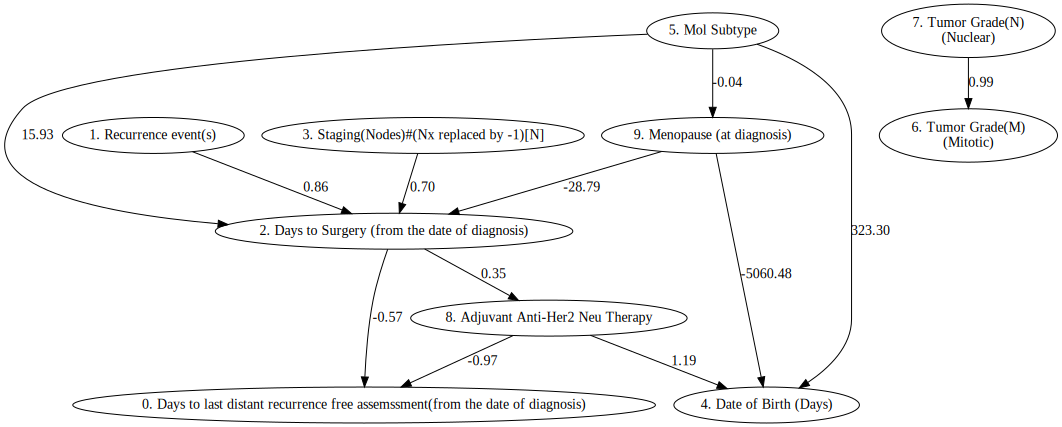

In [ ]:
#create DirectLinGAM object
np.seterr(invalid="ignore")
pk = make_prior_knowledge(
    n_variables=len(X_causal.columns))

model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(X_causal)
labels = [f'{i}. {col}' for i, col in enumerate(X_causal.columns)]
make_graph(model.adjacency_matrix_, labels)